# SpectrogramList と SpectrogramDict のチュートリアル

このノートブックでは、`gwexpy` で新しく導入された `SpectrogramList` および `SpectrogramDict` クラスの使い方を紹介します。

これらのクラスは、複数のスペクトログラムデータ（`gwpy.spectrogram.Spectrogram`）をまとめて管理し、一括して処理（クロップ、再ビン化、プロットなど）を行うためのコンテナです。
時系列データを扱う `TimeSeriesList` / `TimeSeriesDict` と似たインターフェースを持っていますが、2次元データ（時間 × 周波数）を扱う点が特徴です。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from gwexpy.spectrogram import SpectrogramList, SpectrogramDict

## 1. データの準備

まずはデモ用のスペクトログラムデータを作成します。
ここでは、異なる周波数のサイン波を含む時系列データを生成し、それを `spectrogram()` メソッドで変換して使用します。

In [2]:
# サンプルデータの作成
duration = 20  # 秒
sample_rate = 128  # Hz
t = np.linspace(0, duration, int(duration * sample_rate), endpoint=False)

# 10Hz, 30Hz, 50Hz のサイン波 (+ノイズ) を作成
noise_amp = 0.1
ts1 = TimeSeries(
    np.sin(2*np.pi*10*t) + np.random.normal(0, noise_amp, len(t)),
    sample_rate=sample_rate, unit='strain', name='Signal 10Hz'
)
ts2 = TimeSeries(
    np.sin(2*np.pi*30*t) + np.random.normal(0, noise_amp, len(t)),
    sample_rate=sample_rate, unit='strain', name='Signal 30Hz'
)
ts3 = TimeSeries(
    np.sin(2*np.pi*50*t) + np.random.normal(0, noise_amp, len(t)),
    sample_rate=sample_rate, unit='strain', name='Signal 50Hz'
)

# スペクトログラムの計算 (stride=2s, fftlength=1s)
# nproc=1 を指定してシリアル実行による安定化を図ります
spec1 = ts1.spectrogram(2, fftlength=1, overlap=0.5, nproc=1)
spec2 = ts2.spectrogram(2, fftlength=1, overlap=0.5, nproc=1)
spec3 = ts3.spectrogram(2, fftlength=1, overlap=0.5, nproc=1)

print("Spectrogram shape:", spec1.shape)
print("Time range:", spec1.xspan)
print("Freq range:", spec1.yspan)

Spectrogram shape: (10, 65)
Time range: [0.0 ... 20.0)
Freq range: [0.0 ... 65.0)


## 2. SpectrogramList の基本操作

`SpectrogramList` はリストのように振る舞いますが、格納できるのは `Spectrogram` オブジェクトのみです。
初期化時にリストを渡すか、`append()` メソッドで追加します。

In [3]:
# リストの作成
spec_list = SpectrogramList([spec1, spec2])

# 追加
spec_list.append(spec3)

print(f"List length: {len(spec_list)}")
print(f"Items: {[s.name for s in spec_list]}")

List length: 3
Items: ['Signal 10Hz', 'Signal 30Hz', 'Signal 50Hz']


### バッチ処理: 時間軸の切り出し (`crop`)

リスト内のすべてのスペクトログラムに対して、一括で時間軸の切り出しを行います。
**注意:** スペクトログラムはデータ量が大きいため、クロップなどの操作は元のデータを変更せず、新しいオブジェクト（コピー）を返すことがあります。

In [4]:
# 5秒〜15秒の範囲を切り出し
cropped_list = spec_list.crop(5, 15)

print("Original range:", spec_list[0].xspan)
print("Cropped range:", cropped_list[0].xspan)

Original range: [0.0 ... 20.0)
Cropped range: [4.0 ... 14.0)


### バッチ処理: 周波数軸の切り出し (`crop_frequencies`)

gwpyの `Spectrogram` に互換性のあるメソッドがあればそれを使用し、なければ周波数軸を指定してフィルタリングを行います。

In [5]:
# 0Hz 〜 40Hz の範囲を切り出し
freq_cropped = spec_list.crop_frequencies(0, 40)

print("Original yspan:", spec_list[0].yspan)
print("Cropped yspan:", freq_cropped[0].yspan)
# 50Hzの信号を含んでいた3つ目の要素も範囲外の部分はカットされます

Original yspan: [0.0 ... 65.0)
Cropped yspan: [0.0 ... 40.0)


## 3. SpectrogramDict の利用

名前（キー）付きで管理したい場合は `SpectrogramDict` が便利です。

In [6]:
spec_dict = SpectrogramDict({
    "low_freq": spec1,
    "mid_freq": spec2,
    "high_freq": spec3
})

print("Keys:", list(spec_dict.keys()))

Keys: ['low_freq', 'mid_freq', 'high_freq']


## 4. 可視化 (`plot`)

リストや辞書の `.plot()` メソッドを呼ぶと、含まれるすべてのスペクトログラムをまとめてプロットできます。
内部では `gwpy.plot.Plot` を使用しています。

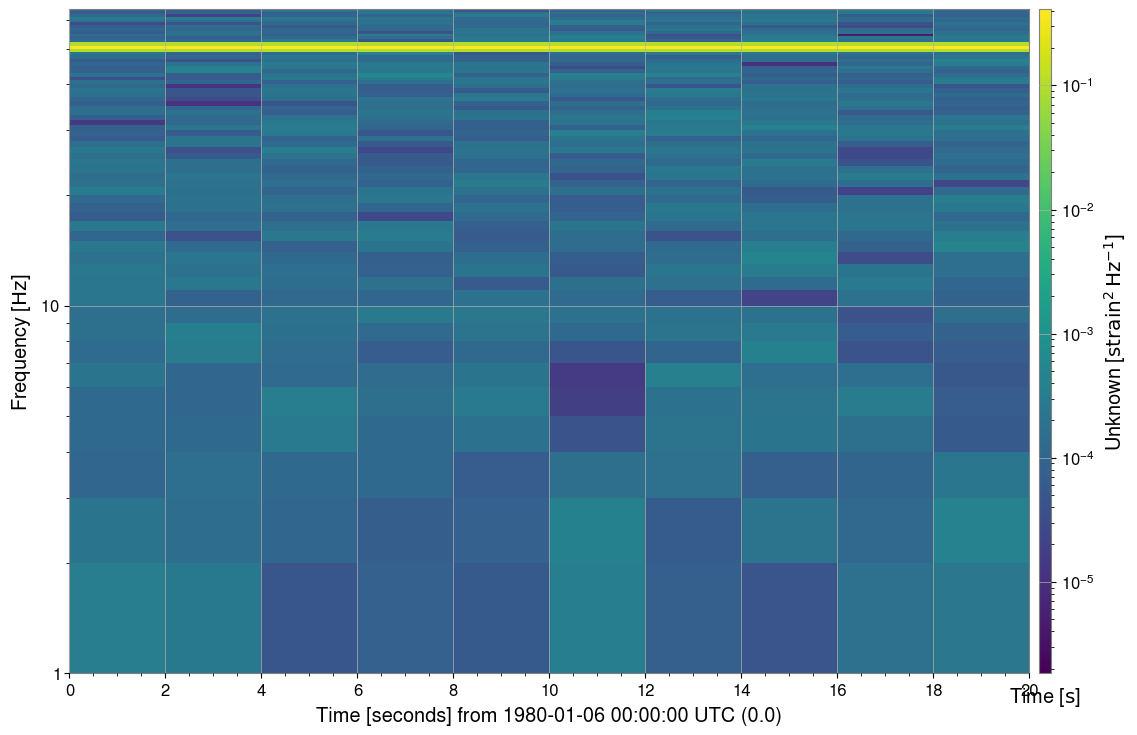

In [7]:
# 一括プロット
# sharex=True, sharey=True にすると軸を共有して比較しやすくなります
plot = spec_dict.plot(figsize=(12, 8), sharex=True, sharey=True)
plt.show()

## 5. マトリックス形式への変換とDeep Learning連携

`to_matrix()` を使用すると、各スペクトログラムを積み重ねた 3次元配列 `(Channels, Time, Frequency)` を持つ `SpectrogramMatrix` オブジェクトを作成できます。

これは機械学習モデル（PyTorch, TensorFlowなど）への入力を作成する際に非常に便利です。

In [8]:
matrix = spec_list.to_matrix()

print("Matrix Type:", type(matrix))
print("Matrix Shape:", matrix.shape)
print("  (N_channels, N_time_steps, N_freq_bins)")

# 属性へのアクセス
print("Time axis shape:", matrix.times.shape)
print("Freq axis shape:", matrix.frequencies.shape)

Matrix Type: <class 'gwexpy.spectrogram.matrix.SpectrogramMatrix'>
Matrix Shape: (3, 10, 65)
  (N_channels, N_time_steps, N_freq_bins)
Time axis shape: (10,)
Freq axis shape: (65,)


PyTorchやCuPyがインストールされていれば、そのままTensor等に変換可能です。

```python
# PyTorch Tensorへの変換
# tensor = matrix.to_torch()
```

## まとめ

これで `SpectrogramList` と `SpectrogramDict` の基本的な使い方の紹介を終わります。
大量のスペクトログラムデータを一括で前処理したり、比較プロットを行う際にぜひ活用してください。